Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Autoencoder network with MedNIST Dataset

This notebook illustrates the use of an autoencoder in MONAI for the purpose of image deblurring/denoising.

# Learning objectives
This will go through the steps of:
* Loading the data from a remote source
* Using a lambda to create a dictionary of images
* Using MONAI's in-built AutoEncoder

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/autoencoder_mednist.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"

## Setup imports

In [ ]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import AutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    EnsureTypeD,
    Lambda,
)
from monai.utils import set_determinism

print_config()

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Create small visualisation function
def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap="gray")
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get the data

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


In [6]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

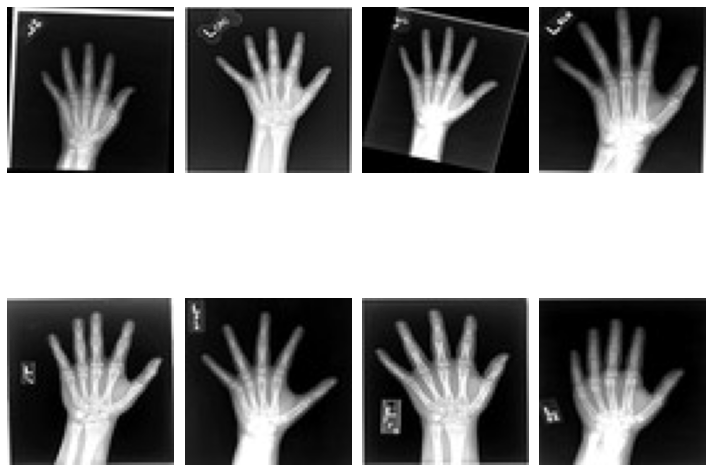

In [7]:
# scan_type could be  AbdomenCT  BreastMRI  CXR  ChestCT  Hand  HeadCT
scan_type = "Hand"
im_dir = os.path.join(data_dir, scan_type)
all_filenames = [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2, 4))

In [8]:
# Split into training and testing
test_frac = 0.2
num_test = int(len(all_filenames) * test_frac)
num_train = len(all_filenames) - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {len(all_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 10000
number of images for training: 8000
number of images for testing: 2000


# Create the image transform chain

To train the autoencoder to de-blur/de-noise our images, we'll want to pass the degraded image into the encoder, but in the loss function, we'll do the comparison with the original, undegraded version. In this sense, the loss function will be minimised when the encode and decode steps manage to remove the degradation.

Other than the fact that one version of the image is degraded and the other is not, we want them to be identical, meaning they need to be generated from the same transforms. The easiest way to do this is via dictionary transforms, where at the end, we have a lambda function that will return a dictionary containing the three images – the original, the Gaussian blurred and the noisy (salt and pepper).

In [9]:
NoiseLambda = Lambda(
    lambda d: {
        "orig": d["im"],
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),
    }
)

train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

### Create dataset and dataloader

Hold data and present batches during training.

In [10]:
batch_size = 300
num_workers = 10

train_ds = CacheDataset(train_datadict, train_transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, test_transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

100%|██████████| 2000/2000 [00:02<00:00, 904.36it/s]


In [11]:
# Get image original and its degraded versions
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=10, shuffle=True)
    itera = iter(loader)
    return next(itera)

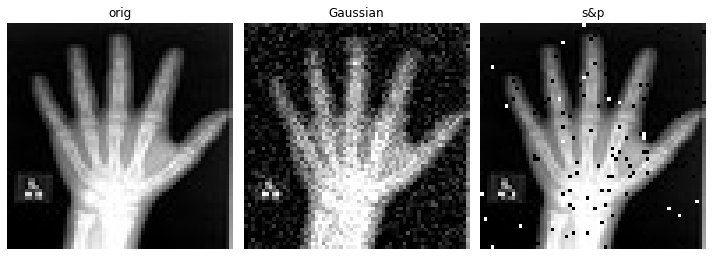

In [12]:
data = get_single_im(train_ds)
plot_ims([data["orig"], data["gaus"], data["s&p"]], titles=["orig", "Gaussian", "s&p"])

In [13]:
def train(dict_key_for_training, max_epochs=10, learning_rate=1e-3):
    model = AutoEncoder(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(4, 8, 16, 32),
        strides=(2, 2, 2, 2),
    ).to(device)

    # Create loss fn and optimiser
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    epoch_loss_values = []

    t = trange(max_epochs, desc=f"{dict_key_for_training} -- epoch 0, avg loss: inf", leave=True)
    for epoch in t:
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data[dict_key_for_training].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, batch_data["orig"].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        t.set_description(f"{dict_key_for_training} -- epoch {epoch + 1}" + f", average loss: {epoch_loss:.4f}")
    return model, epoch_loss_values

In [ ]:
max_epochs = 50
training_types = ["orig", "gaus", "s&p"]
models = []
epoch_losses = []
for training_type in training_types:
    model, epoch_loss = train(training_type, max_epochs=max_epochs)
    models.append(model)
    epoch_losses.append(epoch_loss)

In [ ]:
plt.figure()
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
for y, label in zip(epoch_losses, training_types):
    x = list(range(1, len(y) + 1))
    (line,) = plt.plot(x, y)
    line.set_label(label)
plt.legend()

In [ ]:
data = get_single_im(test_ds)

recons = []
for model, training_type in zip(models, training_types):
    im = data[training_type]
    recon = model(im.to(device)).detach().cpu()
    recons.append(recon)

plot_ims(
    [data["orig"], data["gaus"], data["s&p"]] + recons,
    titles=["orig", "Gaussian", "S&P"] + ["recon w/\n" + x for x in training_types],
    shape=(2, len(training_types)),
)

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)